# Let's build a Little VGG for our model

In [1]:
#importing the libraries
import numpy as np
import keras
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import os

Using TensorFlow backend.


In [2]:
num_classes = 6
img_rows = 48
img_cols = 48
batch_size = 16

In [3]:
#Path of the images
train_data_dir = './train/'
validation_data_dir = './validation/'

In [4]:
#Lets use the data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_set = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


## Little VGG model

In [5]:
model = Sequential()

#Block 1 CONV ==> RELU ==> CONV ==> RELU ==> POOLING
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3) , padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block 2 CONV ==> RELU ==> CONV ==> RELU ==> POOLING
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Blcok 3 CONV ==> RELU ==> CONV ==> RELU ==> POOLING
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Blcok 4 CONV ==> RELU ==> CONV ==> RELU ==> POOLING
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#BLOCK 5: first set of FC ==> RELU layers
model.add(Flatten())
model.add(Dense(units=64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#BLOCK 6: second set of FC ==> RELU layers
model.add(Dense(units=64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Block 7: softmax classifier
model.add(Dense(units = num_classes, kernel_initializer='he_normal' ))
model.add(Activation('softmax'))

#print the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

## Compiling the model

In [6]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(r'D:\\Backup_of_exact_MY_REPO\\Detection of human emotions on images\\human_emotion.h5',
                            monitor = 'val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [checkpoint, early_stop, reduce_lr]

#compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

## Fitting the model

In [7]:
images_on_training_set = 28273
images_on_validation_set = 3534
epochs = 10

In [ ]:
history = model.fit_generator(train_set, 
                              steps_per_epoch = images_on_training_set//batch_size , 
                              epochs= epochs, 
                              verbose=1,
                             callbacks=callbacks, 
                              validation_data = validation_set,
                             validation_steps = images_on_validation_set//batch_size)

I ran the model with the same parameters in the another machine which having higher computation speed than this and and i got the model saved. Now i am going to get the model from there rather than running the above one.

In [8]:
#Loading the model
from keras.models import load_model
classifier = load_model(r'C:\\Users\\Dell\\Desktop\\KPML_practice\\Master Computer Vision\\DeepLearningCV\\Trained Models\\emotion_little_vgg_3.h5')

In [9]:
num_train = 28273
num_val = 3534

In [10]:
#here we need to create the validation generator with shuffle = false to get the prediction correct for each class
validation_generator = validation_datagen.flow_from_directory(
                                                            validation_data_dir,
                                                            color_mode = 'grayscale',
                                                            target_size=(img_rows, img_cols),
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            shuffle= False)

#predicting the validation set
y_pred = classifier.predict_generator(validation_generator, num_val//batch_size+1)

Found 3534 images belonging to 6 classes.


In [11]:
y_pred[1]

array([0.54059464, 0.24996917, 0.06406295, 0.01067813, 0.07242453,
       0.06227062], dtype=float32)

we can see that the y_pred is in probabilities and we need to convert it

In [12]:
y_pred = np.argmax(y_pred, axis=1)

In [13]:
y_pred[1]

0

## Confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_pred, validation_generator.classes)

In [15]:
cm

array([[182,  89,  24,  83,  39,  11],
       [ 42,  37,  12,  32,  29,  23],
       [ 33,  39, 749, 154,  54,  24],
       [100, 130,  54, 173, 222,  20],
       [ 99,  97,  11,  90, 229,   9],
       [ 35, 136,  29,  94,  21, 329]], dtype=int64)

## Get our class labels

In [16]:
class_indices = validation_set.class_indices
print(class_indices)

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


In [17]:
class_indices.items()

dict_items([('Angry', 0), ('Fear', 1), ('Happy', 2), ('Neutral', 3), ('Sad', 4), ('Surprise', 5)])

In [18]:
classes_labels = {v:k for k,v in class_indices.items()}
print(class_indices)

{'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


In [19]:
classes = list(classes_labels.values())
print(classes)

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


([<matplotlib.axis.YTick at 0x2b8446a1390>,
 <a list of 6 Text yticklabel objects>)

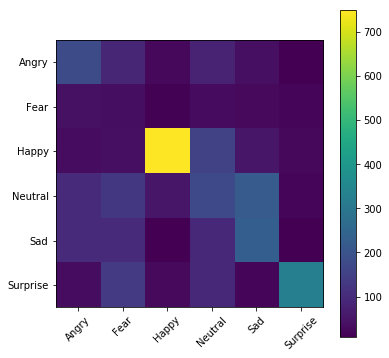

In [20]:
#plot confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

## Let's test on some of the validation images

In [21]:
import os
import random
from keras.preprocessing import image


def draw_test(name, pred, im, true_label):
    Black = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0,0 , 300, cv2.BORDER_CONSTANT, value=Black)
    cv2.putText(expanded_image, 'Predicted -' +str(pred), (20,60), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(expanded_image, 'true -' +str(true_label), (20, 120), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)
    cv2.imwrite('predicted_image{}.jpg'.format(pred), expanded_image)
    
    
    
def random_img_from_val_dir(path):
    #folders inisde validation dir 
    folder_inside_val = os.listdir(path)
    
    #getting random folder number
    n_folders = 6
    random_folder_number = random.choice(list(range(0, n_folders)))
    print(random_folder_number)
    print('label_of_image:' ,classes[random_folder_number])
    
    #listing files inside the random folder
    files_inside_rf = os.listdir(os.path.join(path, folder_inside_val[random_folder_number]))
    
    #selecting random image inside the selected random folder
    random_image_path = os.path.join(path + folder_inside_val[random_folder_number] + '/' +random.choice(files_inside_rf))
    print(random_image_path)
    
    #getting the array of pixels of the random image and convert it into gray
    random_image = cv2.imread(random_image_path, 0)
    
    return random_image, random_image_path, random_folder_number

files = []
true_labels = []
predicted_images = []
#predicting images
for i in range(0,10):
    path_for_random = 'C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images/validation/'
    img, image_path, true_label =random_img_from_val_dir(path_for_random)
    files.append(image_path)
    true_labels.append(classes[true_label])
    x = img/255
    x = np.expand_dims(x, axis = 2) # here axis=2 to get the shape of the image (48,48,1)
    image = x.reshape(-1, img_rows, img_cols, 1)
    #images = np.vstack([x])
    predictions_proba = model.predict(image, batch_size=10)
    predictions = np.argmax(predictions_proba, axis=1)
    predicted_images.append(predictions)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", classes[predicted_images[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

2
label_of_image: Happy
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Happy/696.jpg
3
label_of_image: Neutral
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Neutral/201.jpg
4
label_of_image: Sad
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Sad/347.jpg
5
label_of_image: Surprise
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Surprise/94.jpg
0
label_of_image: Angry
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Angry/126.jpg
4
label_of_image: Sad
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotions on images and webcam/validation/Sad/160.jpg
4
label_of_image: Sad
C:/Users/Dell/Desktop/MY_REPO/Data-Science-Projects/Detecting of human emotio

## Testing on own single image

In [92]:
from keras.preprocessing.image import img_to_array
face_classifier = cv2.CascadeClassifier(r'C:\\Users\\Dell\\Desktop\\KPML_practice\\Master Computer Vision\Master OpenCV\\Haarcascades\haarcascade_frontalface_default.xml')

def detect_face_in_image(img):
    #convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #finding faces in image using cascade
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    
    #if there is no face
    if faces is ():
        return (0,0,0,0) , np.zeros(shape=(0,0), dtype=np.uint8) , img
    
    #if there is a face
    all_faces = []
    rects = []
    for (x,y,w,h) in faces:
        rects.append((x,y,w,h))
        
        #draw rectangle on the image using x,y,w,h
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
        
        #get the region of interset for the faces in the image
        roi_gray = gray[y:y+h , x:x+w]
        roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_AREA)
        
        #get the roi of faces
        all_faces.append(roi_gray)
        
    return rects, all_faces, img

img = cv2.imread(r'C:\\Users\\Dell\\Desktop\\KPML_practice\\Master Computer Vision\\Master OpenCV\\images\Hillary.jpg')
rects, all_faces, image = detect_face_in_image(img)

for face in all_faces:
    roi = face.astype('float') / 255  # here we are represent it as float since it has to give float values not uint8
    roi = img_to_array(roi)
    roi = np.reshape(roi, (-1,48,48,1))
    
    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = classes[preds.argmax()] 
    
    ##Overlay our detected emotion on our pic
    cv2.putText(image, label ,(rects[0][0] -10, rects[0][3]-80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.imwrite('tested_image.jpg', image)
cv2.waitKey(0)

cv2.destroyAllWindows()

# That's the end of the code